# KNN en datos Gaussianos bivariados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Parametros de los datasets Gaussianos
c1 = np.array([0, 0])
c2 = np.array([1, 1])
std1 = 0.5
std2 = 0.5
N = 100

d1 = c1 + np.random.normal(scale=std1, size=(N,2))
d2 = c2 + np.random.normal(scale=std2, size=(N,2))

df1 = pd.DataFrame({'x':d1[:,0], 'y':d1[:,1], 'target':0})
df2 = pd.DataFrame({'x':d2[:,0], 'y':d2[:,1], 'target':1})
df = pd.concat([df1, df2], axis=0, ignore_index=True)

df

,x,y,target
0,0.102930,0.626780,0
1,0.238361,-0.167484,0
2,-0.108555,1.013913,0
3,0.134153,0.463822,0
4,-0.090407,0.392321,0
...,...,...,...
195,1.239346,1.394849,1
196,1.293499,-0.170876,1
197,0.665833,1.438477,1
198,1.988287,0.384725,1


Grafico los datasets:

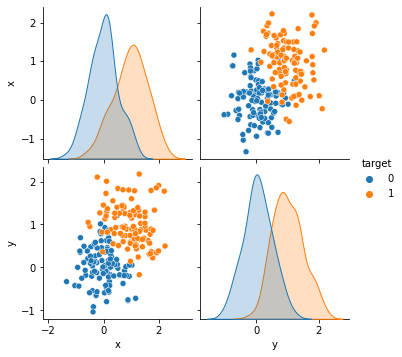

In [2]:
sns.pairplot(df, hue='target', diag_kind='kde')

Para eliminar outliers (siguiendo lo aconsejado en la consigna) divido el dataset segun el target y elimino los outliers de cada subconjunto. Aquí no estoy seguro de que separar según target para eliminar outliers sea lo mejor, pero entiendo que el método de EllipticEnvelope está pensado para conjuntos que siguen una distribución Gaussiana, lo cual es cierto sólo si los separo según target. 

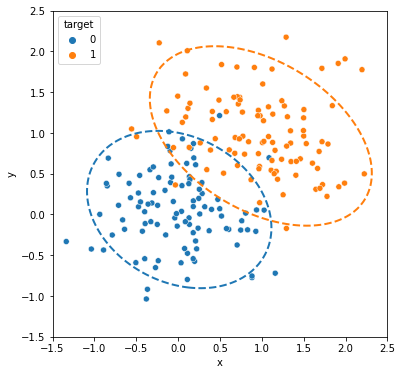

In [3]:
from sklearn.covariance import EllipticEnvelope

clf1 = EllipticEnvelope()
clf2 = EllipticEnvelope()
clf1.fit(df.values[df['target']==0, :2])
clf2.fit(df.values[df['target']==1, :2])

# Dibujo las elipses
x_min, x_max = (np.min([c1[0]-3*std1, c2[0]-3*std2]), np.max([c1[0]+3*std1, c2[0]+3*std2]))
y_min, y_max = (np.min([c1[1]-3*std1, c2[1]-3*std2]), np.max([c1[1]+3*std1, c2[1]+3*std2]))
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z1 = clf1.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(6,6))
sns.scatterplot(x='x', y='y', hue='target', data=df)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors='tab:blue', linestyles='dashed')
plt.contour(xx, yy, Z2, levels=[0], linewidths=2, colors='tab:orange', linestyles='dashed')

Aplico el filtrado de outliers y grafico los datasets sin outliers:

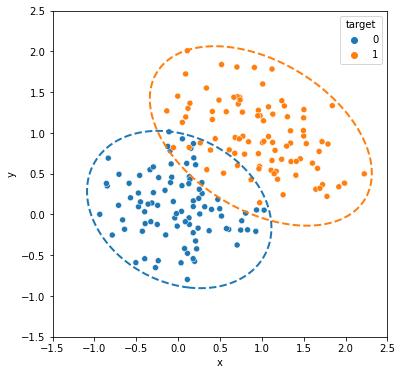

In [4]:
d1_idxs, = np.where(df['target']==0)
d1_outliers = d1_idxs[clf1.predict(df.values[df['target']==0, :2]) == -1]

d2_idxs, = np.where(df['target']==1)
d2_outliers = d2_idxs[clf2.predict(df.values[df['target']==1, :2]) == -1]

outliers = np.hstack((d1_outliers, d2_outliers))
df.drop(outliers, inplace=True)

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z1 = clf1.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(6,6))
sns.scatterplot(x='x', y='y', hue='target', data=df)
plt.contour(xx, yy, Z1, levels=[0], linewidths=2, colors='tab:blue', linestyles='dashed')
plt.contour(xx, yy, Z2, levels=[0], linewidths=2, colors='tab:orange', linestyles='dashed')

Mezclo los datos, divido el dataset en entrenamiento y validación, entreno el modelo y muestro los resultados.

Accuracy: 0.933
Recall: 0.929
Precision: 0.929
F1 score: 0.929 



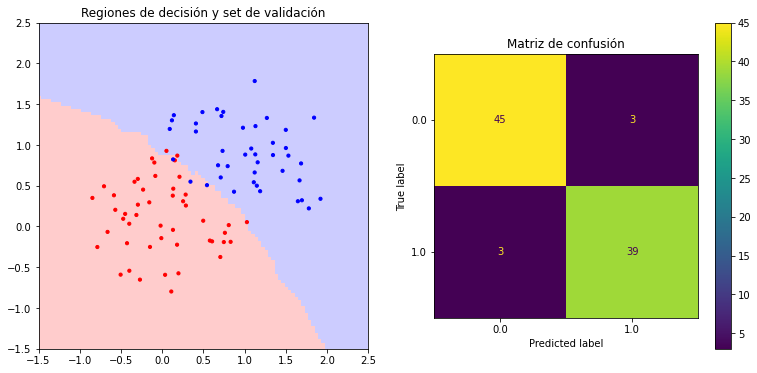

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Parametros del clasificador
k = 10
test_fraction = 0.5

# Separo el dataset en entrenamiento y validación
x_train, x_test, y_train, y_test = train_test_split(df.values[:,:-1], df.values[:,-1], test_size=test_fraction)

# Instancio el modelo y calculo los resultados
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

# Calculo las métricas
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), 3))
print('Recall:', np.round(recall_score(y_test, y_pred), 3))
print('Precision:', np.round(precision_score(y_test, y_pred), 3))
print('F1 score:', np.round(f1_score(y_test, y_pred), 3), '\n')

# Grafico las regiones de decisión y los datos de validación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFCCCC', '#CCFFCC', '#CCCCFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
ax1.pcolormesh(xx, yy, Z, cmap=cmap_light)
ax1.scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=cmap_bold, s=10)
ax1.title.set_text('Regiones de decisión y set de validación')

# Grafico la matriz de confusión
plot_confusion_matrix(knn, x_test, y_test, ax=ax2)
ax2.title.set_text('Matriz de confusión')

Probando diferentes combinaciones se vio que con estos datos (Gaussianos) el valor de K no afecta mucho en el resultado. Para valores grandes de k (k>10) las regiones de decisión son muy similares a las obtenidas con otros métodos, como la clasificación estadística paramétrica. Para valores bajos de k (k<5) la frontera entre las dos regiones se vuelve inestable, dependiendo considerablemente del subconjunto de datos utilizado para entrenamiento (overfitting). Por otro lado, las métricas dependen de la separación aleatoria del dataset en entrenamiento y validación. Aquí se hace evidente la necesidad de utilizar cross-validation para obtener un valor confiable de las métricas que no dependa de la separación del dataset.